Tomography Reconstruction using the filtered back projection algoritm
==
In this lab tutorial, we will program the popular filtered back projection algoritm for tomographic reconstruction of an object given its sinogram collected at equi-angular projections. Reconstruction is first carried out without filtering and then with a linear filter in Fourier space.

In [ ]:
import numpy as np
from math import pi
from matplotlib import pyplot as plt, cm
from scipy import ndimage

reconstruction parameters, start with $N=15$ projections.

In [ ]:
S = 256  # image size and resolution of Fourier space
N = 50  # number of projections in the sinogram

load our data set ```xct256.npy``` using numpy

In [ ]:
image = np.load("./xct256.npy")

we need a function to rotate our image around the center of rotation (here the center of the image)

In [ ]:
from math import cos, sin, pi
from skimage.transform import warp, SimilarityTransform

def rotate(image, angle):
    angle *= 2*np.pi/360  # radians
    center = 0.5 * image.shape[0]  # we assume a square image
    # 2D rotation matrix
    R = np.array([[cos(angle), -sin(angle), 0], [sin(angle), cos(angle),0],[0,0,1]])
    # translation for the image to stay centered
    T = np.array([[-center, -center,0]])

    T = SimilarityTransform(translation=(center,center))
    image = warp(image, T,clip=False)
    # return image
    R = SimilarityTransform(rotation=angle)
    rotated = warp(image, R,clip=False)
    rotated = warp(rotated, T.inverse,clip=False)
    return rotated

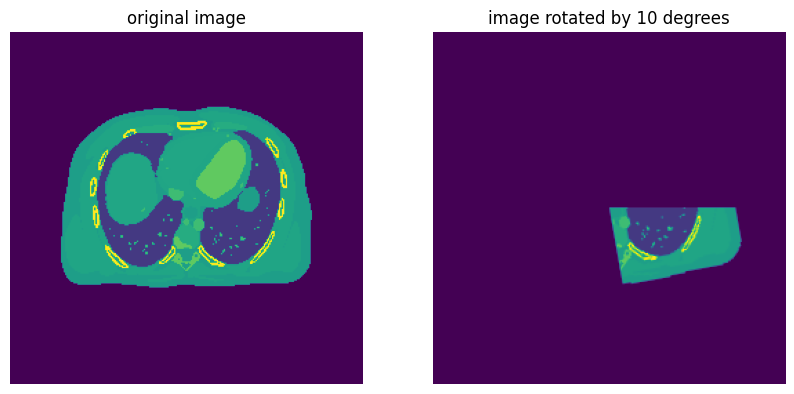

In [ ]:
angle = 10
rotated = rotate(image, angle)
fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
ax[0].imshow(image, aspect='equal')
ax[0].set_title('original image')
ax[0].axis('off')
ax[1].imshow(rotated, aspect='equal')
ax[1].set_title('image rotated by %d degrees' % angle)
ax[1].axis('off')
plt.show()

compute the sinogram of this image so we can work on the projection data for the reconstruction. In practice, the sinogram is obtained experimentally without knowing the internal distribution of the object.

In [ ]:
# initialize a N x S array for the sinogram
sinogram = np.zeros((N,S))
for i in range(N):
    angle = np.degrees(pi * i / N)  # angle in degrees
    # rotate the image using ndimage.rotate with the option reshape=False
    image_rot = ndimage.rotate(image,angle, reshape=False)
    # sum the rotated image to obtain the sinogram row for this angle
    sinogram[i] = image_rot.sum(axis=0)
print(sinogram.shape)

(50, 256)


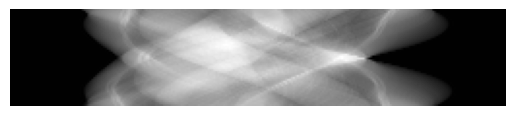

In [ ]:
plt.imshow(sinogram, cmap=cm.gray)
plt.axis('off')
plt.show()

Back projection function
--
We will now create our back projection function. It works by simply smearing out the projection data (each row of the sinogram) over the entire image at the correspinding angle. The vector of the angles must be known for obvious geometric reasons, if not we will assume equi-angular projections over 180 degrees which is given by $\theta=180\times i/N$ for $i\in[0, N[$.

In [ ]:
def rec_bp(sinogram, thetas=None):
    """Tomographic reconstruction using a simple back projection algorithm.

    :param sinogram: a [N x S] numpy array, N is the number of projections, S the size of each projection.
    :param thetas: a vector of the N angular values (in degrees) corresponding to the sinogram.
    :return: the reconstructed slice of the object of size [S x S].
    """
    # get the dimensions
    N, S = sinogram.shape
    # if thetas is not specified, assume equi-angular projections over 180 degrees
    if not thetas:
        thetas = np.linspace(0,180,N,endpoint=False)
        print('using angles: %s' % thetas)
    assert(N == len(thetas))
    # initialize a S xS array for the reconstruction
    rec = np.zeros((S,S))

    # create the coordinates of each pixel, with a reference to the image center
    x = np.arange(S) - S/2
    y = x.copy()
    Y, X = np.meshgrid(y, x)

    # loop on each projection in the sinogram
    for i in range(N):
        # we are going to back project at an angle theta
        theta = thetas[i] * np.pi/180  # use radians
        # compute rotated coordinates using rotation formula
        x_rot = X*np.sin(theta) + Y*np.cos(theta)
        x_fbp = (np.round(x_rot + S / 2)).astype(int)
        # get the corresponding row in the sinogram
        s = sinogram[i]
        # initialize a zero array for the back projection
        back_projection = np.zeros((S, S))
        # create a mask of the acceptable coordinates to remain inside our bounds
        in_x, in_y = np.where((x_fbp >= 0) & (x_fbp < S))
        back_projection[in_x, in_y] = s[x_fbp[in_x, in_y]]
        # simply add the back projection to the reconstruction
        rec += back_projection
    return rec

now try our function on the sinogram we have created

using angles: [  0.  12.  24.  36.  48.  60.  72.  84.  96. 108. 120. 132. 144. 156.
 168.]


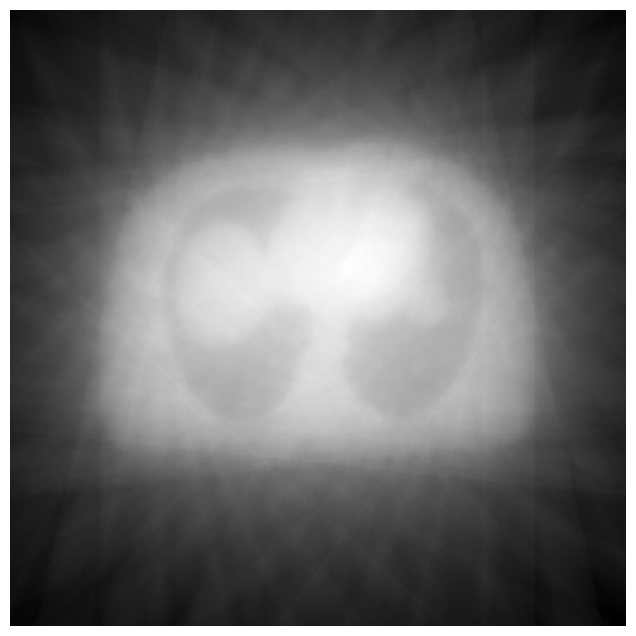

In [ ]:
rec = np.zeros((S,S))
rec = rec_bp(sinogram)
plt.figure(figsize=(8, 8))
plt.imshow(rec, cmap=cm.gray)
plt.axis('off')
plt.show()

Now filter the sinogram before the back projection operation
--
progam a function that will apply a filter in Fourier space to a sinogram.

In [ ]:
from scipy.fftpack import fft, ifft, fftshift

def filter_projections(sinogram):
    """Apply a filter in Fourier space to a sinogram.

    :param sinogram: a [N x S] numpy array, N is the number of projections, S the size of each projection.
    :return: the filtered sinogram as an aray of size [N x S].
    """
    # get the dimensions
    N, S = sinogram.shape
    filtered_sinogram = np.zeros_like(sinogram)
    step = 1 / S
    w = np.arange(-0.5, 0.5, step)

    # define our filter (here a simple ramp)
    r_filter = fftshift(np.pi/N*np.abs(w))

    # now filter each projection of the sinogram in Fourier space
    for i in range(N):
        # take this projection to Fourier space
        proj_fft = fft(sinogram[i])
        # apply filter (multiplication in Fourier space)
        filt_proj_fft = r_filter*proj_fft
        # come back to real space
        filtered_sinogram[i] = np.real(ifft(filt_proj_fft))
    return filtered_sinogram

now retry the reconstruction with our ```rec_bp``` with the filtered projections

using angles: [  0.    3.6   7.2  10.8  14.4  18.   21.6  25.2  28.8  32.4  36.   39.6
  43.2  46.8  50.4  54.   57.6  61.2  64.8  68.4  72.   75.6  79.2  82.8
  86.4  90.   93.6  97.2 100.8 104.4 108.  111.6 115.2 118.8 122.4 126.
 129.6 133.2 136.8 140.4 144.  147.6 151.2 154.8 158.4 162.  165.6 169.2
 172.8 176.4]


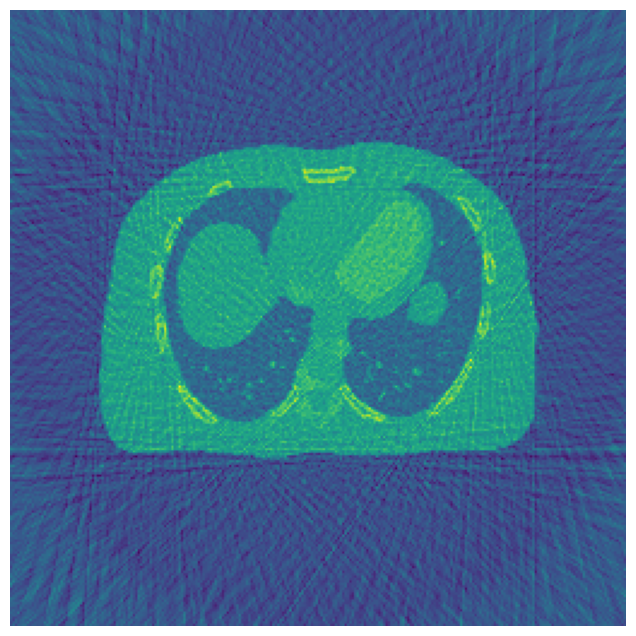

In [ ]:
rec2 = np.zeros((S,S))
rec2 = rec_bp(filter_projections(sinogram))
plt.figure(figsize=(8, 8))
plt.imshow(rec2)#, cmap=cm.gray)
plt.axis('off')
plt.show()

Reconstruction of other samples
--
Here you can try your algorithm on unknown sinograms. You can use data sets ```sinogram1.npy``` and ```sinogram2.npy```.

In [ ]:
sinogram = np.load("sinogram2.npy")
rec3 = rec_bp(filter_projections(sinogram))


using angles: [  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.
  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.
  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.
  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111.
 112. 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124. 125.
 126. 127. 128. 129. 130. 131. 132. 133. 134. 135. 136. 137. 138. 139.
 140. 141. 142. 143. 144. 145. 146. 147. 148. 149. 150. 151. 152. 153.
 154. 155. 156. 157. 158. 159. 160. 161. 162. 163. 164. 165. 166. 167.
 168. 169. 170. 171. 172. 173. 174. 175. 176. 177. 178. 179.]


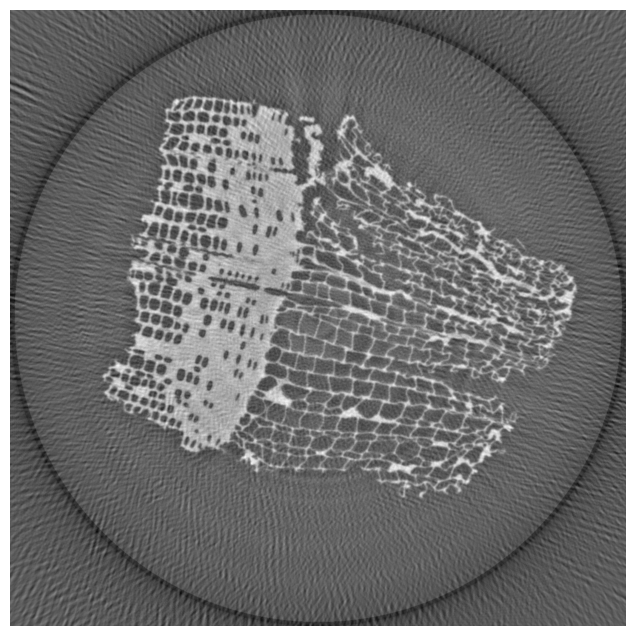

In [ ]:
plt.figure(figsize=(8, 8))
plt.imshow(rec3, cmap=cm.gray)
plt.axis('off')
plt.show()